# Genetic Column Generation: High-dimensional multi-marginal optimal transport

We consider the discrete case throughout this presentation. Let $X$ be a compact subset of $\mathbb{R}^d$ (finite for the discrete problem). $\mathcal{P}_{sym}(X^N)$ denotes the set of symmetric Borel probability measures on $X^N$. Kantorovich plans $\gamma \in \mathcal{P}_{sym}(X^N)$ are symmetric, meaning for all permutations $\sigma$ on $\{1,\ldots,N\}$, we have:

$$
\gamma(A_1 \times \dots \times A_N) =
\gamma(A_{\sigma(1)} \times \dots \times A_{\sigma(N)})
$$

for any Borel subsets $A_1, \dots, A_N \subset X$. The cost function $c: X^N \to \mathbb{R}$ is continuous, and the marginal is $\lambda^* \in \mathcal{P}(X)$.

## Discretization

Assuming $X$ is discretized into $l$ points:

$$
X = \{ a_1, \dots, a_l \}
$$

Then the marginal is:

$$
\lambda^* = \sum_{i=1}^{l} m_i \delta_{a_i}
\quad \text{with } m_i \ge 0, \; \sum_{i=1}^l m_i = 1
$$

where $m_i$ is the mass at $a_i$. The Kantorovich plan $\gamma$ can be viewed as a tensor $(\gamma_{i_1, \dots, i_N})$ of order $N$:

$$
\gamma = \sum_{i_1, \dots, i_N=1}^{l}
\gamma_{i_1 \dots i_N} \delta_{a_{i_1}} \otimes
\dots \otimes \delta_{a_{i_N}}
$$

## Discretized Symmetric Multi-Marginal OT

The primal problem is:

$$
\min_{\gamma \in \mathcal{P}_{sym}(X^N)}
C[\gamma] = \sum_{i_1, \dots, i_N = 1}^{l}
\gamma_{i_1 \dots i_N} c(a_{i_1}, \dots, a_{i_N})
$$

subject to:

$$
\sum_{i_2, \dots, i_N = 1}^{l}
\gamma_{i_1, i_2, \dots, i_N} = \lambda^*(\{a_{i_1}\})
\quad \forall i_1 \in \{ 1, \dots, l \}
$$

The associated dual problem is:

$$
\max_{y \in \mathbb{R}^l} \sum_{i=1}^{l} y_i \lambda^*(\{a_i\})
$$

subject to:

$$
\frac{1}{N} \left( y_{i_1} + \dots + y_{i_{N}} \right)
\le c(a_{i_1}, \dots, a_{i_N})
\quad \forall i_1, \dots, i_N \in \{ 1, ..., l \}
$$

## Drawbacks of Primal and Dual Problems

The primal problem has $l^N$ unknowns and $l$ constraints, whereas the dual problem has $l$ unknowns and $l^N$ constraints.

## Extremal Formulation

To reduce the problem dimension, we use extreme points and the column generation algorithm.

**Extreme Points Definition:** A point $s$ in a convex set $S$ of a vector space is extreme if:

$$
\nexists x, y \in S, x \neq y \text{ and } 0 < t < 1 : s = t x + (1 - t) y
$$

## Extremal Formulation of Optimal Transport

Define the set of $1/N$ quantized probability measures $\lambda \in \mathcal{P}(X)$:

$$
\mathcal{P}_{1/N}(X) =
\left\{
\lambda \in \mathcal{P}(X) :
\lambda(\{a_i\}) \in \left\{ \frac{0}{N}, \frac{1}{N}, ..., \frac{N}{N} \right\}
\;\; \forall i \in \{ 1, ..., l \}
\right\}
$$

Any $\gamma \in \mathcal{P}_{sym}(X^N)$ can be uniquely expressed as a convex combination of extreme points $\gamma_{\lambda} \in \mathcal{P}_{sym}(X^N)$:

$$
\gamma = \sum_{\lambda \in \mathcal{P}_{1/N}(X)} \alpha_{\lambda} \gamma_{\lambda}
\quad \text{with } \alpha_{\lambda} \ge 0, \;\; \sum_{\lambda \in \mathcal{P}_{1/N}(X)} \alpha_{\lambda} = 1
$$

## More About the Extremal Points

1. Dirac measures $\delta_{a_{i_k}}$ are extreme points of $\mathcal{P}(X)$. In the discrete case, the only extreme points are Dirac measures.

2. Any measure $\lambda \in \mathcal{P}(X)$ can be written as a convex combination of these extreme points.

**The process:**

1. Fix $\lambda \in \mathcal{P}_{1/N}(X)$, with:

$$
\lambda = \frac{1}{N} \sum_{k=1}^N \delta_{a_{i_k}}
$$

where $a_{i_k} \in X$ can be repetitive.

2. Define:

$$
\tilde{\gamma}_\lambda = \prod_{k=1}^N \delta_{a_{i_k}} = \delta_{(a_{i_1}, \dots, a_{i_N})}
$$

which is an extreme point (Dirac measure on $X^N$).

3. Define:

$$
\gamma_\lambda = S_N(\tilde{\gamma}_\lambda) \in \mathcal{P}_{sym}(X^N)
$$

where $S_N$ is a symmetrizer:

$$
S_N(\tau)(A_1 \times \cdots \times A_N) = \frac{1}{N!} \sum_{\sigma \in \text{PER}} \tau(A_{\sigma(1)} \times \cdots \times A_{\sigma(N)})
$$

Thus:

$$
\gamma_\lambda = \frac{1}{N!} \sum_{\sigma \in \text{PER}} \delta_{(a_{i_{\sigma(1)}}, \dots, a_{i_{\sigma(N)}})}
$$

## Rewriting the MMOT Problem

The minimization problem can be stated as:

$$
\min_{\alpha \in \mathbb{R}^{\binom{N+l-1}{N}}} \sum_{\lambda \in \mathcal{P}_{1/N}(X)} c_{\lambda} \alpha_{\lambda}
$$

subject to:

$$
A \alpha = \lambda^*
$$

where:

$$
c_{\lambda} = \sum_{i_1, \dots, i_N=1}^{l} (\gamma_{\lambda})_{i_1 \dots i_N} c(a_{i_1}, \dots, a_{i_N})
$$

## Complexity

The number of unknowns is $\binom{N + l - 1}{N}$, which can still be large for conventional methods.

## Column Generation

1. Choose a small subset $I \subset \overline{I} = \{ 1, 2, \dots, \binom{N + l - 1}{N} \}$.

2. Denote $A_I$ as a submatrix of $A$ (corresponding to $I$ columns), $c_I$ as a submatrix of $c$.

   The Primal Problem becomes the Restricted Master Problem (RMP):

   $$
   \min_{\alpha \in \mathbb{R}^{\sharp I}} c_I^T \alpha
   $$

   subject to:

   $$
   A_I \alpha = \lambda^*
   \quad \alpha \ge 0
   $$

3. The Dual of the Restricted Master Problem is:

   $$
   \max_{y \in \mathbb{R}^l} y^T \lambda^*
   $$

   subject to:

   $$
   A_I^T y \le c_I
   $$

4. Use the solution $y^*$ of the Dual to solve the Pricing Problem:

   $$
   \max \; \lambda^T y^* - c_{\lambda}
   $$

   subject to:

   $$
   \lambda \in \mathcal{P}_{1/N}(X)
   $$

   Note: The problem is NP-complete.

## Genetic Method of Columns Generation

1. **Selection:** Allow only columns $\lambda$ with positive coefficients $\alpha_{\lambda}$ to be parents, picking parents randomly.

2. **Mutation:** Search for the nearest neighbor of the parent in the column space $\mathcal{P}_{1/N}(X)$ with respect to the Wasserstein-1 distance (induced by the Euclidean metric). Move one particle to the nearest location.

3. **Recombination:** Combine parents with crossover probability to form new columns.

4. **Algorithm Iteration:** Generate columns that can further reduce the cost and update the matrix until convergence.
   After several iterations, the algorithm converges to an optimal solution.


In [1]:
import random

import numpy as np
from scipy.optimize import linprog
from matplotlib import pyplot as plt

from itertools import permutations

from tqdm import trange

The matrix $A_I$ is initialized with $l \times l$ identity matrix and then we add $(\beta -1) \times l$ random columns.

In [2]:
def place_at_bin(arr, N):
    max_choice = N - arr.sum()
    i = random.randint(0, max_choice)
    index = random.choice(np.where(arr == 0)[0])
    arr[index] = i


def generate_random_cols(N, matrix_size):
    A = np.zeros(matrix_size)
    i = 0
    while i < matrix_size[1]:
        while A[:, i].sum() != N:
            place_at_bin(A[:, i], N)
        # check for any repetitions
        for j in range(i):
            if np.all(A[:, j] == A[:, i]):
                A[:, i] = 0
                i -= 1
        i += 1
    return A / N

In [3]:
def initialize_AI(N, grid_size, beta=5):
    A = np.eye(grid_size)
    random_cols = generate_random_cols(N, (grid_size, beta - 1))
    return np.hstack((A, random_cols))


The cost $c = \sum_{1 \le i < j \le N} w(a_i, a_j)$ has a faster way to compute
$$ c_{\lambda} = \frac{N^2}{2} \lambda^T C \lambda - \frac{N}{2} diag(C)^T \lambda. $$

See
1. Gero Friesecke and Daniela Vögler. Breaking the Curse of Dimension in Multi-Marginal
Kantorovich Optimal Transport on Finite State Spaces. SIAM J. Math. Anal., 50(4):39964019, 2018.
2. Gero Friesecke, Andreas S. Schulz and Daniela Vögler. Genetic column generation: Fast computation of high-dimensional multi-marginal optimal transport problems.

In [4]:


def solve_rmp(AI, cI, marginal):
    result = linprog(cI, A_eq=AI, b_eq=marginal, bounds=(0, None))
    return result.x, result.fun


def solve_dual(AI, cI, marginal):
    c_dual = -marginal  # because linprog does minimization
    result = linprog(c_dual, A_ub=AI.T, b_ub=cI,
                     bounds=[(None, 0) for _ in range(AI.shape[0])],
                     method='highs')
    return result.x


def mutate_parent(parent, grid_size):
    child = parent.copy()
    change_index = random.choice(np.where(parent > 0)[0])
    direction = random.choice([-1, 1])
    destination = max(min(grid_size-1, change_index + direction), 0)
    child[destination] += parent[change_index]
    child[change_index] -= parent[change_index]
    child /= child.sum()
    return child


def compute_cost(lambd, N, cost_matrix: np.ndarray):
    return (N**2/2 * lambd.T @ cost_matrix @ lambd -
            N/2 * cost_matrix.diagonal().T @ lambd)

In [5]:
def genetic_column_generation(
        N,
        l,
        beta,
        pair_potential,
        coordinates_of_sites,
        marginal,
        maxiter,
        maxsamples
):
    a, b = coordinates_of_sites
    x = y = np.linspace(a, b, l)
    X, Y = np.meshgrid(x, y, indexing='ij')
    cost_matrix = pair_potential(X, Y)
    AI = initialize_AI(N, l)

    cI = np.empty(AI.shape[1])
    for j in range(AI.shape[1]):
        cI[j] = compute_cost(AI[:, j], N, cost_matrix)
    samples = 0
    iter = 0
    gain = -1

    cost_history = np.empty((maxiter, 1))
    dual_value_history = np.empty((maxiter, l))

    with trange(maxiter) as t:
        for i in t:
            alpha_I, cost = solve_rmp(AI, cI, marginal)
            cost_history[i] = cost
            y_star = solve_dual(AI, cI, marginal)
            dual_value_history[i, :] = y_star

            while gain <= 0 and samples <= maxsamples:
                # Select a random active column of AI
                parent_index = random.choice(np.where(alpha_I > 0)[0])
                parent = AI[:, parent_index]
                child = mutate_parent(parent, l)
                c_child = compute_cost(child, N, cost_matrix)

                # Calculate gain from adding the child column
                gain = np.dot(child.T, y_star) - c_child

                samples += 1

            # Update AI and cI with the new child column if there's a positive gain
            if gain > 0:
                AI = np.hstack((AI, child[:, np.newaxis]))
                cI = np.append(cI, c_child)
                if AI.shape[1] > beta * l:
                    # Clear the oldest inactive columns
                    inactive_indices = np.where(alpha_I == 0)[0]
                    AI = np.delete(AI, inactive_indices[:l], axis=1)
                    cI = np.delete(cI, inactive_indices[:l])

            iter += 1

            t.set_postfix(samples=samples, cost=cost)

    # Return the final set of columns and configuration
    alpha_I, cost = solve_rmp(AI, cI, marginal)
    cost_history[i] = cost
    y_star = solve_dual(AI, cI, marginal)
    dual_value_history[i, :] = y_star
    return AI, alpha_I, cost_history, dual_value_history


We set the marginal $\lambda^*$ as

$$ \lambda^* (\{ a_i \}) = c_0 \cdot \left(0.2 + \sin^2 \left(\pi \frac{i}{l+1}\right)\right) $$

where the constant $c_0$ is set such that $\sum \lambda^* (\{a_i\}) = 1$.

And we use the regularized Coulomb interaction
$$ w(a_i, a_j) = \frac{1}{\sqrt{\varepsilon^2 + |a_i - a_j|^2}}. $$

In [6]:
N = 10  # Number of marginals
l = 120  # Number of sites
beta = 5  # Hyperparameter for controlling the maximum columns
maxiter = 8000  # Maximum number of iterations
# maxsamples = 1000  # Maximum number of samples for mutations

grid_points = np.arange(1, l+1)

marginal = 0.2 + np.power(np.sin(np.pi * grid_points / (l+1)), 2)
marginal /= marginal.sum()


def pair_potential(x, y, eps=0.1):
    "Use regulatized Coulomb interaction"
    return 1 / np.sqrt(eps**2 + np.power(x - y, 2))

In [7]:
print("1-DIMENSIONAL SETTING.")
print(f"Number of marginals {N=}")
print(f"Number of grid points {l=}")
print(f"Hyperparameter for controlling the maximum columns {beta=}")
print(f"Maximum number of iterations {maxiter=}")

1-DIMENSIONAL SETTING.
Number of marginals N=10
Number of grid points l=120
Hyperparameter for controlling the maximum columns beta=5
Maximum number of iterations maxiter=8000


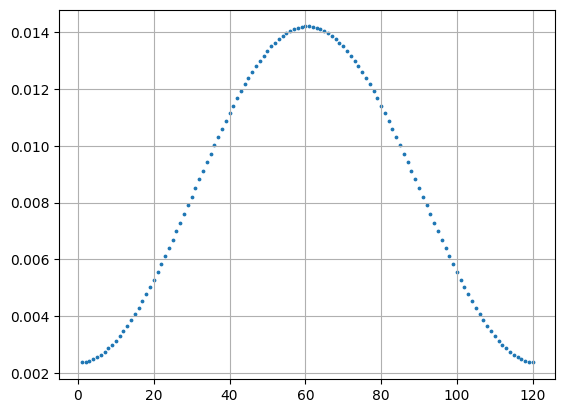

In [8]:
plt.scatter(grid_points, marginal, s=3)
plt.grid()

In [9]:
ai, alpha, cost_history, dual_value_history = genetic_column_generation(
    N, l, beta, pair_potential, (0, 1), marginal, maxiter, 100000)

100%|██████████| 8000/8000 [00:44<00:00, 178.03it/s, cost=444, samples=1e+5]


gamma.shape=(120,)


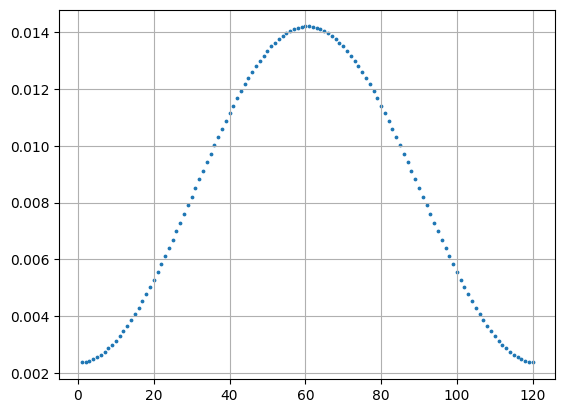

In [10]:
gamma = ai @ alpha
print(f"{gamma.shape=}")

plt.scatter(grid_points, gamma, s=3)
plt.grid()
plt.show()